# PyTorch mutual information neural estimation image-based tests

Image-based high-dimensional tests

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import torchkld
import mutinfo

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 2


In [5]:
from tqdm import tqdm

In [6]:
from mutinfo.distributions.base import *

In [7]:
from misc.modules import *
from misc.plots import *
from misc.utils import *

## Dataset

Experimental setup

In [8]:
mutual_information = 10.0

dataset_type = "gaussians"
assert dataset_type in ["rectangles", "gaussians"]

min_delta = 0.1 # Minimum (normalized) width/height for rectangles to avoid singularity.

In [9]:
image_width  = 32
image_height = 32

X_size = image_width
Y_size = image_width

In [10]:
from mutinfo.distributions import mapped
from mutinfo.distributions.images.geometric import uniform_to_rectangle, draw_rectangle
from mutinfo.distributions.images.field import draw_field, symmetric_gaussian_field

if dataset_type == "rectangles":
    X_latent_dimension = 4
    Y_latent_dimension = 4

    def generation_mapping(x, y):
        x = draw_rectangle(uniform_to_rectangle(ndtr(x), min_delta, min_delta), image_width, image_height)
        y = draw_rectangle(uniform_to_rectangle(ndtr(y), min_delta, min_delta), image_width, image_height)
        
        return x, y

    random_variable = mapped.mapped_multi_rv_frozen(
        CorrelatedNormal(mutual_information, X_latent_dimension, Y_latent_dimension, randomize_correlation=False),
        generation_mapping
    )
    
elif dataset_type == "gaussians":
    X_latent_dimension = 2
    Y_latent_dimension = 2

    def generation_mapping(x, y):
        x = draw_field(ndtr(x), symmetric_gaussian_field, (image_width, image_height))
        y = draw_field(ndtr(y), symmetric_gaussian_field, (image_width, image_height))
        
        return x, y

    random_variable = mapped.mapped_multi_rv_frozen(
        CorrelatedNormal(mutual_information, X_latent_dimension, Y_latent_dimension, randomize_correlation=False),
        generation_mapping
    )

In [11]:
n_samples = 10*1024
x, y = random_variable.rvs(n_samples)

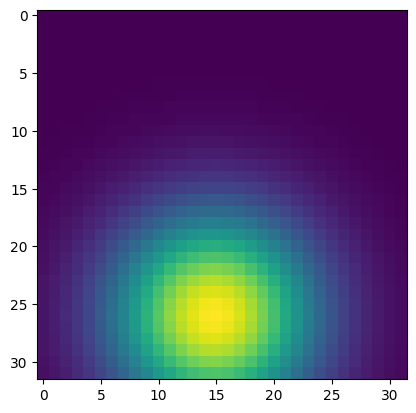

In [12]:
plt.imshow(random_variable.rvs(10)[0][0])

In [13]:
from mutinfo.estimators.knn import KSG
from sklearn.decomposition import PCA

In [14]:
ksg = KSG()
#ksg(PCA(image_width*image_height).fit_transform(x.reshape(x.shape[0], -1)), PCA(image_width*image_height).fit_transform(y.reshape(y.shape[0], -1)), std=True)
#ksg(x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1), std=True)

## Estimating MI

Dataset and dataloader

In [15]:
batch_size = 128
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x, dtype=torch.float32)[:,None,...],
    torch.tensor(y, dtype=torch.float32)[:,None,...],
    torch.tensor(x[np.random.permutation(x.shape[0])], dtype=torch.float32)[:,None,...]
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Model

In [16]:
n_filters = 8
hidden_dimension = 128

model = BasicConv2dT(X_size, Y_size, n_filters=n_filters, hidden_dimension=hidden_dimension).to(device)
total_parameters = sum(parameter.numel() for parameter in model.parameters())
print(f"Total parameters: {total_parameters}")

Total parameters: 52033


Loss

In [17]:
# Loss.
biased = False
ema_multiplier = 1.0e-2
marginalize = "permute" # "permute", "product"

losses = {
    "DonskerVaradhan": torchkld.loss.DonskerVaradhanLoss(biased=biased, ema_multiplier=ema_multiplier),
    "NWJ": torchkld.loss.NWJLoss(),
    "Nishiyama": torchkld.loss.NishiyamaLoss(),
}

loss_name = "DonskerVaradhan"
loss = losses[loss_name]

Optimizer

In [18]:
learning_rate = 1.0e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training

In [19]:
import matplotlib
from matplotlib import pyplot as plt

In [20]:
# Number of epochs used to average the estimate.
average_epochs = 200

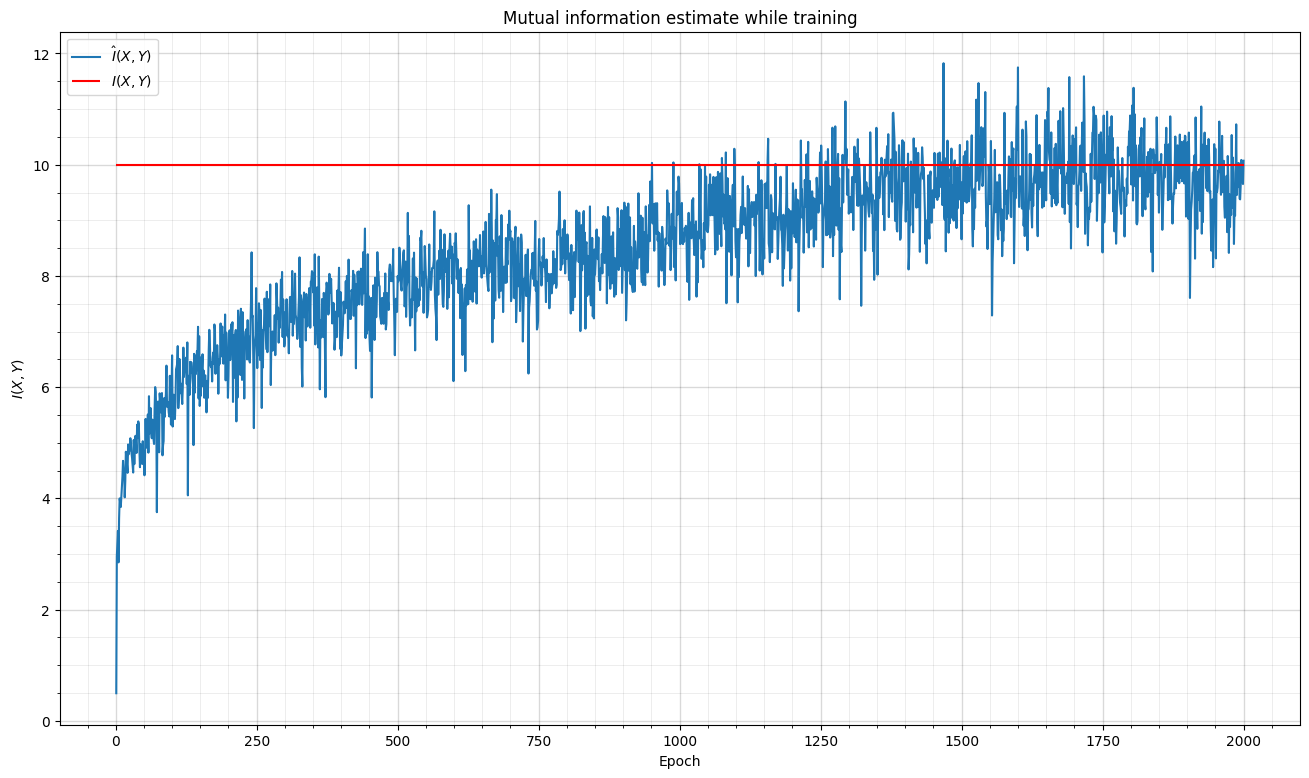

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [54:38<00:00,  1.64s/it]

Current estimate: 10.07
Running median: 9.81


In [21]:
from IPython.display import clear_output
from tqdm import trange
n_epochs = 2000

history = {"mutual_information": []}
for epoch in trange(1, n_epochs + 1, mininterval=1):    
    # Training.
    for index, batch in enumerate(dataloader):
        x, y, z = batch
        batch_size = x.shape[0]
        
        optimizer.zero_grad()
        
        T_joined   = model(x.to(device), y.to(device))
        T_marginal = model(x.to(device), y.to(device), marginalize=marginalize)
        _loss = loss(T_joined, T_marginal)
        _loss.backward()
        
        optimizer.step()
        
    history["mutual_information"].append(model.get_mutual_information(dataloader, loss, device))

    if epoch % 50 == 0:
        clear_output(wait=True)
        plot_estimated_MI_trainig(mutual_information, np.arange(1, epoch+1), history["mutual_information"])
        print(f"Current estimate: {history['mutual_information'][-1]:.2f}")
        print(f"Running median: {np.median(history['mutual_information'][-average_epochs:]):.2f}")

### Saving the results

In [22]:
parameters = {
    # Dataset.
    "dataset_type": dataset_type,
    "X_latent_dimension": X_latent_dimension,
    "Y_latent_dimension": Y_latent_dimension,
    "image_width": image_width,
    "image_height": image_height,
    "mutual_information": mutual_information,

    # Model.
    "n_filters": n_filters,
    "hidden_dimension": hidden_dimension,

    # Loss.
    "loss_name": loss_name,
    "biased": biased,
    "ema_multiplier": ema_multiplier,

    # Training.
    "n_samples": n_samples,
    "batch_size": batch_size,
    "n_epochs": n_epochs,
    "learning_rate": learning_rate,

    # Saving the results.
    "average_epochs": average_epochs,
}

In [23]:
from datetime import datetime

experiment_name = f"{dataset_type}_{image_width}x{image_height}_{mutual_information:.1f}_{n_samples}__{datetime.now().strftime('%d-%b-%Y_%H:%M:%S')}"
print(experiment_name)

gaussians_32x32_10.0_10240__25-Jul-2024_16:16:25


In [24]:
import os
from pathlib import Path

data_path = Path(os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), "../../data/synthetic")))
experiment_path = data_path / f"{dataset_type}_{image_width}x{image_height}" / loss_name / experiment_name

In [25]:
save_results(history, parameters, experiment_path, average_epochs=average_epochs)